# Introduction

`judgyprophet` is a library for Bayesian forecasting with judgmental adjustment. As the name suggests, it is based in part upon the library `prophet`, in that it is built around the concept of changepoints. As opposed to `prophet` though, `judgyprophet` uses informative priors for these changepoints, to encode known future business events. 

Once these events occur, the prior is updated based on what is observed, in the standard Bayesian way. We have found in practice for structural timeseries, where changepoint dates are known, and the teams on the ground have a good estimate of what is going to happen; `judgyprophet` has the potential to dramatically beat conventional 'actuals + regressor' based forecasting methods in a backtest.

## Tutorial 1: Level Event

In this tutorial we use `judgyprophet` to forecast a timeseries with a level event. First, let's fetch the data:

In [1]:
from judgyprophet.tutorials.resources import get_level_event

example_data = get_level_event()
print(example_data.head())

2019-01-01    3.287609
2019-02-01    4.753766
2019-03-01    3.955497
2019-04-01    4.451812
2019-05-01    5.345102
Freq: MS, dtype: float64


The code above shows the format of the data required by `judgyprophet`. The data should be a `pandas Series`, with the actuals as the entries. 

The index should denote the datetime element of the series, it should be ordered and have no gaps. It can either be a pandas index for specifically working with timeseries (e.g. `pd.DatetimeIndex`), or just an integer based index -- this means you don't have to explicitly list dates. If it is a pandas timeseries index, the `freq` should be set. This allows `judgyprophet` to calculate the horizon during prediction. In our case the `freq` is set to be 'MS', meaning month start.

Our example data has a `pd.DatetimeIndex`.

Let's plot the data...

<AxesSubplot:>

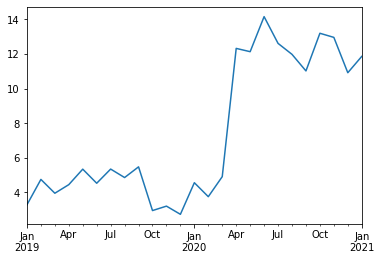

In [2]:
example_data.plot.line()

We can see a relatively stable constant trajectory, followed by a shift in that trajectory around April 2020. It is quite stable after that.

In `judgyprophet` we would call this event a `level_event`; it is a change in the level of the timeseries. Suppose in January 2020, we talk to the business and they suggest an event is likely to happen in April 2020 that will change the level by approximately 10. We would encode this in `judgyprophet` as follows:

In [3]:
level_events = [
    {'name': 'Expected event 1', 'index': '2020-04-01', 'c0': 10}
]

Each level event is encoded as a `dict` with two required entries: the `'index'` field, which is the index in the data when the event occurs. If this entry is fed into `example_data.loc[]`, then it should return a single value. It follows the standard `pandas` indexing rules (for example, see [here](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)). The `'c0'` field is the initial estimate by the business of what the impact of this level event will be. It is fed into the model as an informative prior on the level event mean; which is then updated in a Bayesian way.

Now let's pretend we're still in January 2020, and see what `judgyprophet` would have forecast

In [4]:
from judgyprophet import JudgyProphet

# Cutoff the data to January 2020
data_jan2020 = example_data.loc[:"2020-01-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_jan2020,
    level_events=level_events,
    trend_events=[],
    sigma_base_bias=.1,
    sigma_base_trend=.1,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Post-event data for level event Expected event 1 less than 0 points. Event deactivated in model. Event index: 2020-04-01, training data end index: 2019-01-01 00:00:00


Initial log joint probability = -111.513
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       3      -25.5963      0.311734   7.74003e-14           1           1        6   
Optimization terminated normally: 
  Convergence detected: gradient norm is below tolerance


Let's plot the results...

<AxesSubplot:xlabel='ds', ylabel='value'>

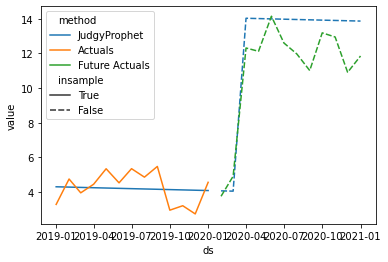

In [5]:
import pandas as pd
import seaborn as sns

predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_jan2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-02-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

We can see from the plot that the forecast captures the event pretty well. However the business estimate of the change-in-level event is probably slightly too high; which leads to the forecast to slightly overshoot the actuals.

This is where the Bayesian updating comes into its own. Let's now fit the forecast after the event has occurred. At this point, the impact of the event will be updated in a Bayesian way given what has been seen in the actuals.

In [6]:
# Cutoff the data to June 2020
data_june2020 = example_data.loc[:"2020-06-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_june2020,
    level_events=level_events,
    trend_events=[],
    sigma_base_bias=1.,
    sigma_base_trend=1.,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding level event Expected event 1 to model. Event index: 2020-04-01, training data start index: 2019-01-01 00:00:00, training data end index: 2020-06-01 00:00:00. Initial level: 10.


Initial log joint probability = -6.3286
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       6      -2.93197    0.00010066   0.000432255           1           1        9   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Plotting the results again:

<AxesSubplot:xlabel='ds', ylabel='value'>

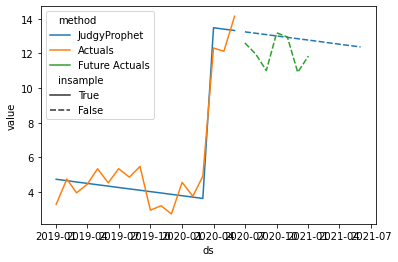

In [7]:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_june2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-07-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

When `judgyprophet` predicts after the event occurs, it decreases the business estimate as it observes actuals.

## Tutorial 2: Trend Events

In this tutorial, we demonstrate `judgyprophet` when there is a trend event that will occur that the business is aware of. First let's plot the data...

2019-06-01    3.287609
2019-07-01    5.753766
2019-08-01    5.955497
2019-09-01    7.451812
2019-10-01    9.345102
Freq: MS, dtype: float64


<AxesSubplot:>

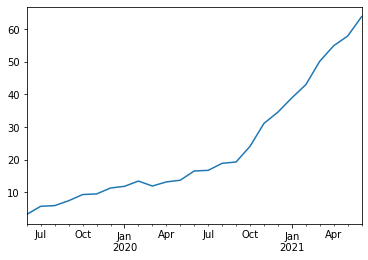

In [8]:
from judgyprophet.tutorials.resources import get_trend_event

example_data = get_trend_event()
print(example_data.head())
example_data.plot.line()

We can see from the plot that there is an uptick in trend around September 2020.

Suppose we talk to the business in April 2020, and they suggest that the product will be launched in a new market, and this will likely lead to an uptick in the sales gradient of 5. We can encode this in `judgyprophet` as an expected trend event as follows:

In [9]:
trend_events = [
    {'name': "New market entry", 'index': '2020-09-01', 'm0': 6}
]

Each trend event is encoded as a dict with two required entries: the 'index' field, which is the index in the data when the event occurs. If this entry is fed into example_data.loc[], then it should return a single value. It follows the standard pandas indexing rules (for example, see here). The 'm0' field is the initial estimate by the business of what the impact of this event on the trend will be (e.g. in our case we estimate it will increase the trend by 5). It is fed into the model as an informative prior on the level event mean; which is then updated in a Bayesian way.

Now let's pretend we're still in April 2020, and see what `judgyprophet` would have forecast

In [10]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
data_apr2020 = example_data.loc[:"2020-04-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_apr2020,
    level_events=[],
    trend_events=trend_events,
    sigma_base_bias=1.,
    sigma_base_trend=1.,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.


Initial log joint probability = -23.3478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       5      -2.70162   2.64101e-05   0.000127726           1           1        8   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


Plotting the results:

<AxesSubplot:xlabel='ds', ylabel='value'>

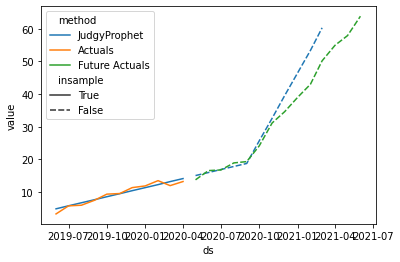

In [11]:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_apr2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-05-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

We can see that with the business information, the forecast is better able to handle the sudden uptick in trend. After a while though, we can see that the business estimate of the trend is an overestimate. Let's see if the Bayesian updating can account for this. We now suppose we are re-forecasting the product in January 2021.

In [12]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
data_jan2021 = example_data.loc[:"2021-01-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_jan2021,
    level_events=[],
    trend_events=trend_events,
    unspecified_changepoints=0,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New market entry to model. Event index: 2020-09-01, training data start index: 2019-06-01 00:00:00, training data end index: 2021-01-01 00:00:00. Initial gradient: 6. Damping: None.


Initial log joint probability = -27.3436
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       6      -1.64341   8.11489e-05    1.1948e-05           1           1        9   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

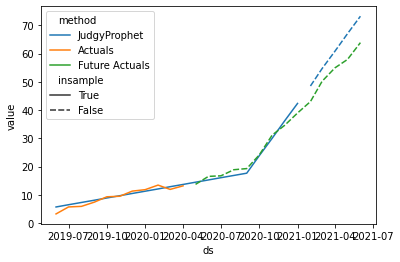

In [13]:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[predictions.index <= "2021-06-01", ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_apr2020.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2020-05-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

Although the forecast is still a slight overestimate, the Bayesian updating has downgraded the initial estimate somewhat.

### Damping

Often when a product is released to a new market, there is a period of strong uptake initially, followed by a slowing of uptake as the market saturates. We model this in `judgyprophet` by using damping. The damping model is a linear trend with damping, which is the same as that used in one of the most popular exponential smoothing methods: Holt's linear damped trend (see [here](https://otexts.com/fpp3/holt.html#damped-trend-methods)).

Unlike the trend and level parameters, the damping is set by the user, and is not learnt during fitting. This is because we found learning using Bayesian fitting to be inaccurate. If you are not sure what the damping term should be we recommend using cross-validation, or observing similar market launches. The damping term is usually between 0.8 and 1 (where 1 means no damping, i.e. a linear model), it is equivalent to the $\phi$ parameter in the description of Holt's linear damped trend.

Those who know Prophet will remember it modelled this using logistic curves. We found this was extremely sensitive to the choice of the capacity parameter $C$ (the population the new entrant would eventually reach). Which is why we opted for the damped linear trend, which we found to be more flexible.

Let's look at a curve with damping

2019-06-01    3.287609
2019-07-01    5.253766
2019-08-01    4.955497
2019-09-01    5.951812
2019-10-01    7.345102
Freq: MS, dtype: float64


<AxesSubplot:>

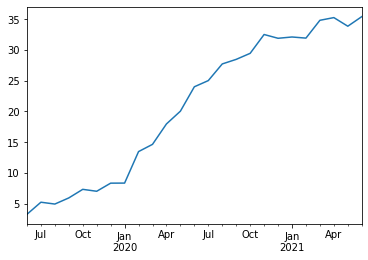

In [14]:
from judgyprophet.tutorials.resources import get_damped_trend_event

example_data = get_damped_trend_event()
print(example_data.head())
example_data.plot.line()

We can see there is an initial uptick in trend, followed by a plateauing effect as the market saturates. We talk to the business and they assume the initial trend uptake is 5, with a damping parameter from analysing similar market entrants of .9. We encode this as a `trend_event` as follows, notice that we refer to the damping parameter as `gamma`:

In [15]:
trend_events = [
    {'name': "New saturating market entry", 'index': '2020-01-01', 'm0': 5, 'gamma': .85}
]

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.


Initial log joint probability = -2.112
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       6      -2.08579   6.33188e-05   6.58776e-05           1           1        8   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

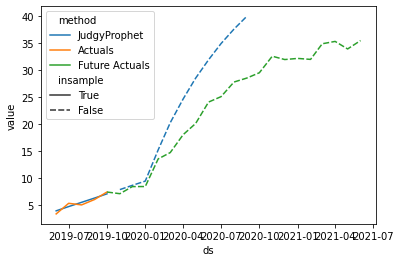

In [16]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
data_oct2019 = example_data.loc[:"2019-10-01"]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_oct2019,
    level_events=[],
    trend_events=trend_events,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_oct2019.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc["2019-10-01":]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

We can see the initial estimates are quite off this time. This is because the business overestimated the damping and the trend. Let's see what happens as we start to observe actuals.

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2020-01-01, training data start index: 2019-06-01 00:00:00, training data end index: 2020-04-01 00:00:00. Initial gradient: 5. Damping: 0.85.


Initial log joint probability = -26.8453
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
       8      -2.49061   7.99148e-05   0.000636667           1           1       11   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

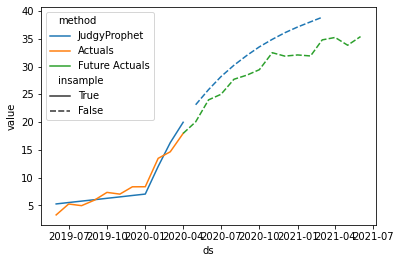

In [17]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
cutoff = "2020-04-01"
data_cutoff = example_data.loc[:cutoff]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_cutoff,
    level_events=[],
    trend_events=trend_events,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

While the trend is still a little overestimated, it is definitely improving. But is there anything we can do to improve the situation?

### Unspecified Changepoints

Like prophet, we enable the user to include unspecified changepoints into the forecast. Unexpected changepoints enables us to handle unexpected changes in the trend of level of the timeseries. This is done by setting the `unspecified_changepoints` parameter in the `fit` method of `JudgyProphet`. Unspecified changepoints are initially set to have no effect on the model, but if actuals are observed that deviate from the model, they will be 'turned on,' and change the model.

The arg `unspecified_changepoints` either takes an integer as input, which will intersperse the changepoints equally across time, or a list of indexes, which will place changepoints at exactly those time points. These changepoints are given a Laplace prior with a mean of 0, and a scale set by the arg `sigma_unspecified_changepoints`. The `sigma_unspecified_changepoints` affects the L1 penalty on the unspecified changepoints. Set `sigma` to be high (e.g. .5 or greater) and the unspecified changepoints will be very sensitive. Set it low (e.g. 0.05), and it will be insensitive.

Unlike prophet, setting these changepoints does not change the prediction. Only `level_events` and `trend_events` in the prediction horizon will affect the forecast. Let's see what affect these have on the previous damping example...

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2020-01-01, training data start index: 2019-06-01 00:00:00, training data end index: 2020-04-01 00:00:00. Initial gradient: 5. Damping: 0.85.


Initial log joint probability = -7.38204
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -2.78894    0.00958924       12.3864           1           1       26   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32      -2.54413    0.00225599       13.1547   0.0002131       0.001       79  LS failed, Hessian reset 
      39      -2.51841   5.09762e-05       11.5457      0.2162           1       90   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -2.51713   8.71303e-07       12.1944       1.633      0.1633      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67      -2.51713   3.69276e-09       12.1799     0.04036           1      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


/Users/kpxh622/github/judgyprophet/judgyprophet/utils.py:37: UserWarning: Unspecified changepoint with index 2020-01-01 00:00:00 also specified as a level or trend event. Removing this changepoint.
  warnings.warn(msg)


<AxesSubplot:xlabel='ds', ylabel='value'>

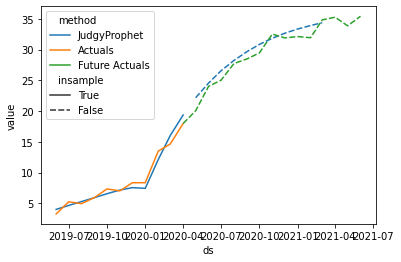

In [18]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns

# Cutoff the data to January 2020
cutoff = "2020-04-01"
data_cutoff = example_data.loc[:cutoff]

# Make the forecast with the business estimated level event
# We have no trend events, so just provide the empty list.
jp = JudgyProphet()
# Because the event is beyond the actuals, judgyprophet throws a warning.
#    This is just because the Bayesian model at the event has no actuals to learn from.
#    The event is still used in predictions.
jp.fit(
    data=data_cutoff,
    level_events=[],
    unspecified_changepoints=10,
    sigma_unspecified_changepoints=.2,
    trend_events=trend_events,
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=12)

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

We can see in this case the unspecified changepoints have improved the model fit significantly. We recommend caution with unspecified changepoints though, they come with a cost, and when your timeseries is quite noisy they might be overreactive. In this case it is recommended to tune your `sigma_unspecified_changepoints` accordingly, or limit the amount of changepoints you use.

## Other Parameters: Seasonality and Hyperparameters

Similar to `prophet`, `judgyprophet` models seasonality as Fourier series and can handle both additive and multiplicative seasonality.

To enable seasonality, simply set the `seasonal_period` arg to a positive integer (e.g. 12 for monthly data, 7 for daily). The default seasonality is additive, to change this to multiplicative set the arg `seasonal_type` to be `'mult'`. The Fourier order is set via the `fourier_order` parameter, with the default value set to `seasonal_period` - 1.

### Additive Seasonality

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.


Initial log joint probability = -800.121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      11      -1.34071   1.16672e-05   0.000492509           1           1       20   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


<AxesSubplot:xlabel='ds', ylabel='value'>

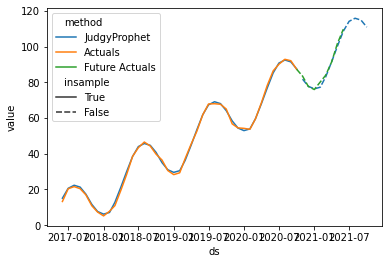

In [19]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns
from judgyprophet.tutorials.resources import get_additive_seasonality_linear_trend

example_data = get_additive_seasonality_linear_trend()


# Cutoff the data to October 2020
cutoff = "2020-10-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# We are passing in a simple time series without trend or level events. The seasonality is set to 12
#     and the seasonality component is simply additive.
jp.fit(
    data=data_cutoff,
    level_events=[],
    trend_events=[],
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(12))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

### Multiplicative Seasonality

INFO:judgyprophet.judgyprophet:Rescaling by shifting all values positive with 1-sd.


Initial log joint probability = -17395
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -159.832     0.0517489       2320.38      0.6585      0.6585       27   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -76.6983      0.411613       467.764      0.2593      0.2593       60   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       -1.0156     0.0932464       84.8291           1           1       92   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79     -0.317823    0.00171814       7.43865           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99     -0.286685   0.000499939       1.98596      0.7391      0.7391      143   
    Iter      log prob        ||dx||      ||grad||       alpha    

<AxesSubplot:xlabel='ds', ylabel='value'>

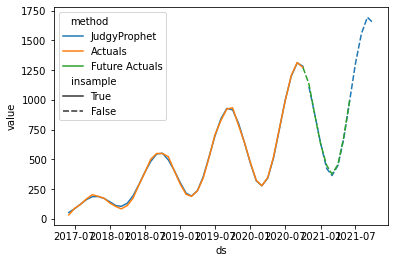

In [20]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns
from judgyprophet.tutorials.resources import get_multiplicative_seasonality_linear_trend

example_data = get_multiplicative_seasonality_linear_trend()


# Cutoff the data to October 2020
cutoff = "2020-10-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# The multiplicative example time series has a constant trend component, but the seasonality
#     is multiplicative and has a large amplitude. Again the period is set to 12.
jp.fit(
    data=data_cutoff,
    level_events=[],
    trend_events=[],
    seasonal_period=12,
    seasonal_type="mult",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(12))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

### Bringing it all together: Additive Seasonality with a trend event

INFO:judgyprophet.judgyprophet:Rescaling onto 0-mean, 1-sd.
INFO:judgyprophet.judgyprophet:Adding trend event New saturating market entry to model. Event index: 2020-01-01, training data start index: 2017-06-01 00:00:00, training data end index: 2020-10-01 00:00:00. Initial gradient: 5. Damping: 0.85.


Initial log joint probability = -5083.65
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      19      -10.0318     0.0134467       160.641      0.1395           1       27   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39      -4.38199    0.00597253       61.6303      0.2684      0.2684       55   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59      -2.42236     0.0105244       101.783           1           1       82   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79      -1.92227    0.00604441       26.6881      0.3227           1      109   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99      -1.77642    0.00158768       35.4472           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha  

/Users/kpxh622/github/judgyprophet/judgyprophet/utils.py:37: UserWarning: Unspecified changepoint with index 2020-01-01 00:00:00 also specified as a level or trend event. Removing this changepoint.
  warnings.warn(msg)


<AxesSubplot:xlabel='ds', ylabel='value'>

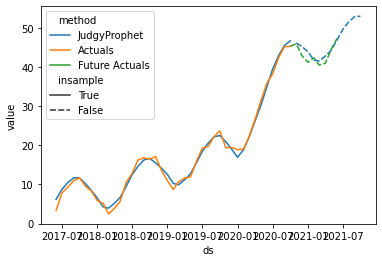

In [21]:
from judgyprophet import JudgyProphet
import pandas as pd
import seaborn as sns
from judgyprophet.tutorials.resources import get_additive_seasonal_damped_trend_event

example_data = get_additive_seasonal_damped_trend_event()


# Cutoff the data to October 2020
cutoff = "2020-10-01"
data_cutoff = example_data.loc[:cutoff]

jp = JudgyProphet()
# We have one trend event and no level events. The seasonality is additive again.
jp.fit(
    data=data_cutoff,
    level_events=[],
    unspecified_changepoints=10,
    sigma_unspecified_changepoints=.2,
    trend_events=trend_events,
    seasonal_period=12,
    seasonal_type="add",
    # Set random seed for reproducibility
    seed=13
)
predictions = jp.predict(horizon=int(12))

# Plot the data:
predict_df = (
    predictions.reset_index()
    .rename(columns={'index': 'ds', 'forecast': 'value'})
    .assign(method="JudgyProphet")
    .loc[:, ["ds", "value", "insample", "method"]]
)
actuals_df = (
    data_cutoff.reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Actuals", insample=True)
)
future_actuals_df = (
    example_data.loc[cutoff:]
    .reset_index()
    .rename(columns={'index': 'ds', 0: 'value'})
    .assign(method="Future Actuals", insample=False)
)
plot_df = (
    pd.concat([predict_df, actuals_df, future_actuals_df])
    .reset_index(drop=True)
)

sns.lineplot(data=plot_df, x='ds', y='value', hue='method', style='insample', style_order=[True, False])

### Hyperparameters

`judgyprophet` gives full control over hyperparameters. These are mainly scale parameters which determine how sensitive `judgyprophet` is to actuals. The most useful of these are:

* `sigma_level` -- each level event is assigned a Normal prior with mean the business estimate ('c0'), and standard deviation is set to this arg. The lower this is, the closer the event will follow the business suggestions -- its default is 0.1.
* `sigma_trend` -- each trend event is assigned a Normal prior with mean the business estimate ('m0'), and standard deviation is set to this arg. The lower this is, the closer the event will follow the business suggestions -- its default is 0.1.
* `sigma_unspecified_changepoints` -- each unspecified changepoint is assigned a Laplace prior (equivalent to L1 penalty) with mean 0, and standard deviation set to this arg. The lower this is, the less likely the model will use this changepoint.

Other hyperparameters are:

* `sigma_base_bias` -- the initial bias is assigned a Normal prior with mean 0, and standard deviation is set to this arg. The lower this is, the more this parameter will be penalised down. Default 1.
* `sigma_base_trend` -- the initial trend is assigned a Normal prior with mean 0, and standard deviation is set to this arg. The lower this is, the more this parameter will be penalised down. Default 1.
* `sigma_seasonal` -- the seasonality parameters are assigned a Normal prior with mean 0, and standard deviation is set to this arg. The lower this is, the more this parameter will be penalised down. Default 1.